In [45]:
import torch
import segmentation_models_pytorch as smp
import yaml
import glob
import numpy as np
import matplotlib.pyplot as plt

from wpsml.data import ERA5Dataset, ToTensor, NormalizeState
from torchvision import transforms
import gc

In [4]:
config_file = "../results/casper/1209/unet/model.yml"

In [7]:
with open(config_file) as cf:
    conf = yaml.load(cf, Loader=yaml.FullLoader)

In [24]:
save_loc = "../results/casper/1209/unet/"  # conf['save_loc']

device = "cuda"

In [18]:
# datasets (zarr reader)
all_ERA_files = sorted(glob.glob(conf["data"]["save_loc"]))

# Specify the years for each set
test_years = [
    str(year) for year in range(2018, 2022)
]  # same as graphcast -- always hold out

# Filter the files for each set
test_files = [
    file for file in all_ERA_files if any(year in file for year in test_years)
]

test_dataset = ERA5Dataset(
    filenames=test_files,
    transform=transforms.Compose(
        [
            NormalizeState(conf["data"]["mean_path"], conf["data"]["std_path"]),
            ToTensor(),
        ]
    ),
)


# setup the dataloder for this process
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=2,
    shuffle=False,
    pin_memory=True,
    num_workers=0,
    drop_last=True,
)

In [19]:
def cycle(dl):
    while True:
        for data in dl:
            yield data


# cycle for later so we can accum grad dataloader
dl = cycle(test_loader)

In [27]:
# model
model = smp.Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    decoder_attention_type="scse",
    in_channels=67,  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=67,  # model output channels (number of classes in your dataset)
).to(device)

In [25]:
checkpoint = torch.load(f"{save_loc}/checkpoint.pt", map_location=device)

In [28]:
model.load_state_dict(checkpoint["model_state_dict"])

<All keys matched successfully>

In [39]:
def concat_and_reshape(x1, x2):
    # Reshape x and y1 to (b, c*f, h, w)
    x1 = x1.view(x1.shape[0], -1, x1.shape[3], x1.shape[4])
    # Concatenate along the width dimension
    x_concat = torch.cat((x1, x2), dim=1)
    return x_concat

In [40]:
def split_and_reshape(tensor):
    # Split the tensor into two
    tensor1 = tensor[:, :60, :, :]  # shape: (b, 60, h, w)
    tensor2 = tensor[:, -7:, :, :]  # shape: (b, 7, h, w)

    # Reshape tensor1 from (b, 60, h, w) to (b, 4, 15, h, w)
    tensor1 = tensor1.view(tensor1.shape[0], 4, 15, tensor1.shape[2], tensor1.shape[3])

    return tensor1, tensor2

In [ ]:
batch = next(dl)

In [46]:
x = batch["x"][0:1].to(device)
y1 = batch["y1"][0:1].to(device)
x_surf = batch["x_surf"][0:1].to(device)
y1_surf = batch["y1_surf"][0:1].to(device)

In [34]:
# # Reshape x and y1 to (b, c*f, h, w)
# x = x.view(x.shape[0], -1, x.shape[3], x.shape[4])
# y1 = y1.view(y1.shape[0], -1, y1.shape[3], y1.shape[4])

# # Concatenate along the width dimension
# x = torch.cat((x, x_surf), dim=1)
# y = torch.cat((y1, y1_surf), dim=1)

In [47]:
x = concat_and_reshape(x, x_surf)
y = concat_and_reshape(y1, y1_surf)

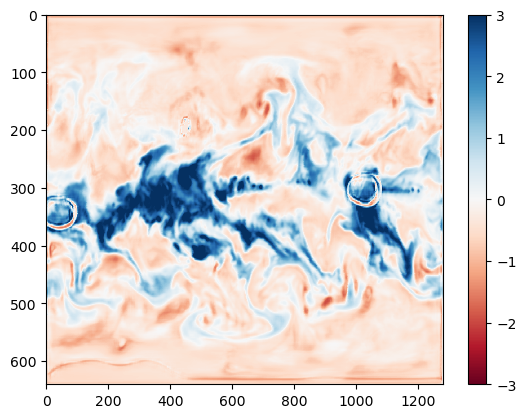

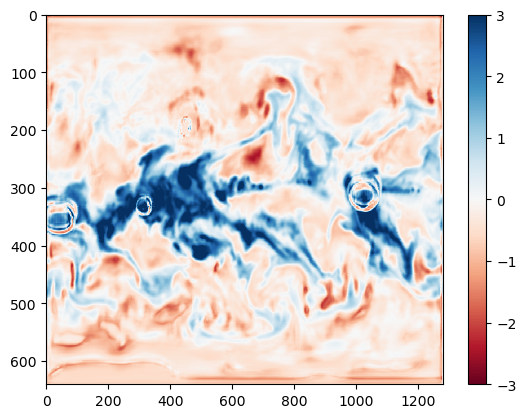

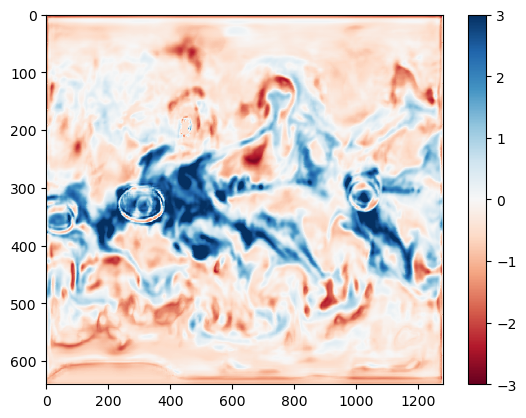

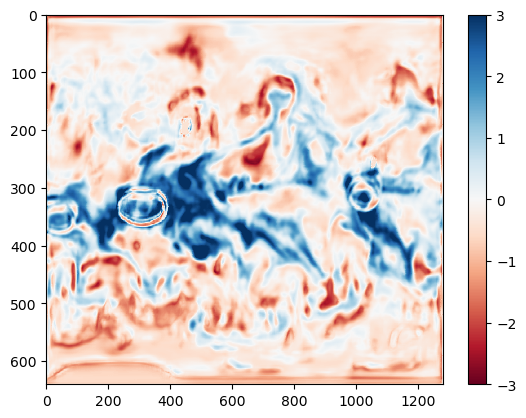

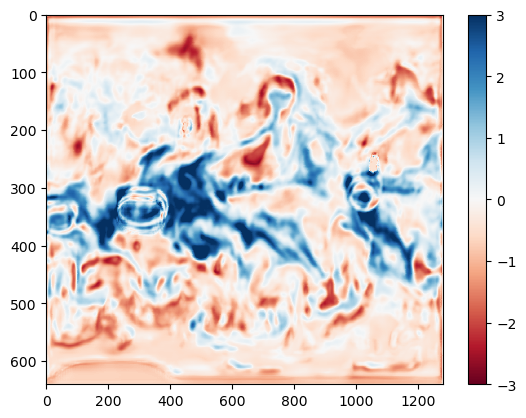

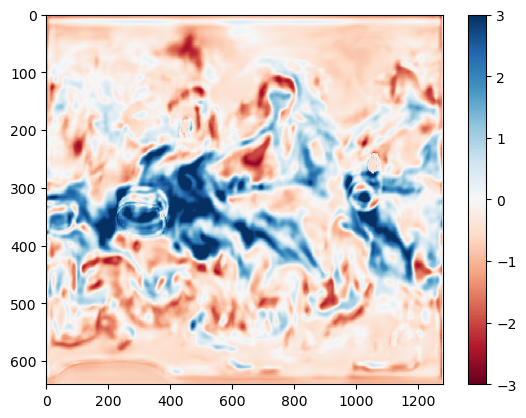

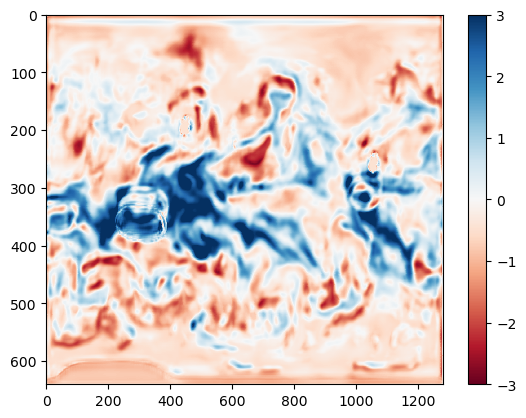

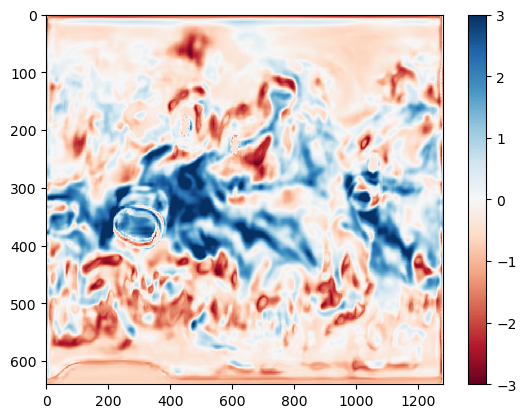

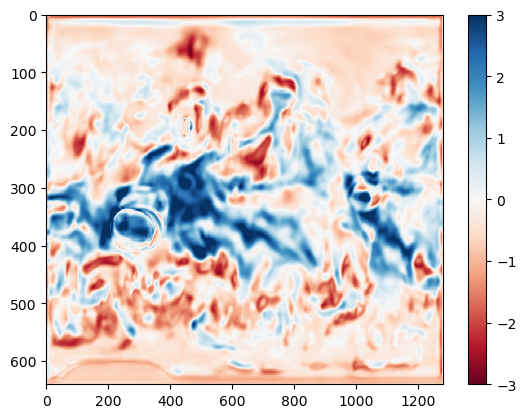

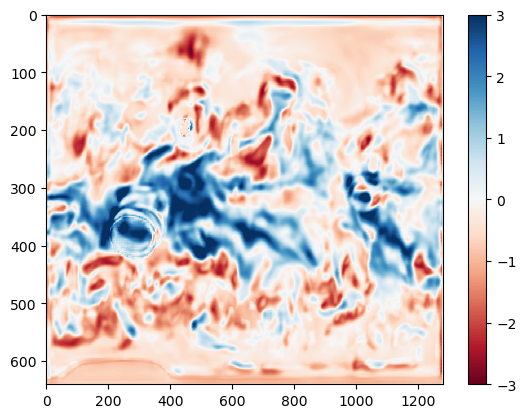

In [61]:
sv_np = np.zeros([20, 4, 15, 640, 1280])
sv_np_surf = np.zeros([20, 7, 640, 1280])

with torch.no_grad():
    for dd in range(10):
        if dd == 0:
            y1_pred_tot = model(x)
            y1_pred, y1_pred_surf = split_and_reshape(y1_pred_tot)
            sv_np[dd, :, :, :, :] = y1_pred[0, :, :, :].to("cpu").numpy()
            sv_np_surf[dd, :, :, :] = y1_pred_surf[0, :, :, :].to("cpu").numpy()

        else:
            predvar1 = torch.from_numpy(
                np.expand_dims(sv_np[dd - 1, :, :, :, :], axis=0)
            ).float()
            predvar2 = torch.from_numpy(
                np.expand_dims(sv_np_surf[dd - 1, :, :, :], axis=0)
            ).float()
            predvar = concat_and_reshape(predvar1, predvar2)
            y1_pred_tot = model(predvar.to(device))
            y1_pred, y1_pred_surf = split_and_reshape(y1_pred_tot)
            sv_np[dd, :, :, :, :] = y1_pred[0, :, :, :].to("cpu").numpy()
            sv_np_surf[dd, :, :, :] = y1_pred_surf[0, :, :, :].to("cpu").numpy()

        # Optionally, if you don't need to keep the previous y1_pred values, overwrite it
        plt.pcolor(
            y1_pred_surf[0, 6, :, :].to("cpu").numpy(), cmap="RdBu", vmin=-3, vmax=3
        )
        plt.colorbar()
        plt.gca().invert_yaxis()
        plt.show()

        del y1_pred, y1_pred_surf
        # Explicitly release GPU memory
        torch.cuda.empty_cache()
        gc.collect()

In [76]:
import numpy as np


def compute_power_spectrum(image):
    # Compute the 2D Fourier Transform
    fft = np.fft.fft2(image)

    # Compute power spectrum
    power_spectrum = np.abs(fft) ** 2

    return power_spectrum


def fourier_mse(image1, image2):
    # Compute power spectra of both images
    power_spectrum1 = compute_power_spectrum(image1)
    power_spectrum2 = compute_power_spectrum(image2)

    # Compute the mean squared error between power spectra
    mse = np.mean((power_spectrum1 - power_spectrum2) ** 2)
    return mse

In [79]:
# Generate random grayscale images
image1 = np.random.randint(0, 256, (256, 256), dtype=np.uint8) / 255.0
image2 = np.random.randint(0, 256, (256, 256), dtype=np.uint8) / 255.0

# Compute similarity
similarity = fourier_image_similarity(image1, image1 + 1e-07)

print(f"The similarity score is {similarity}")

The similarity score is 2.826983537643968
